<a href="https://colab.research.google.com/github/Sohaib90/Pytorch-projects-uni-random-/blob/master/Task2P3_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install https://github.com/pytorch/text/archive/master.zip
!pip install inscriptis

In [0]:
import torch    # root package
import numpy as np
from torch.utils.data import Dataset, DataLoader 

In [33]:
"""
Load the AG_NEWS dataset in bi-gram features format.
"""
# !pip install https://github.com/pytorch/text/archive/master.zip
import torch
import torchtext
from torchtext.datasets import text_classification
import os

NGRAMS = 2

if not os.path.isdir('./.data'):
    os.mkdir('./.data')

train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
    root='./.data', ngrams=NGRAMS, vocab=None)

BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

120000lines [00:07, 16196.24lines/s]
120000lines [00:15, 7704.11lines/s]
7600lines [00:01, 7557.61lines/s]


In [0]:
print(len(train_dataset.get_labels()))
print(test_dataset[1])

In [0]:
# TODO: Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

BATCH_SIZE = 32
loss_name = "BCELoss"

In [0]:
class LSTMmodel(nn.Module):
  def __init__(self, vocab_size, hidden_dim, dim_embed, num_classes, dropout_gate = 0): 
    super(LSTMmodel, self).__init__()

    self.dropout_gate = dropout_gate
    self.hidden_dim = hidden_dim
    self.embeddings = nn.EmbeddingBag(vocab_size, dim_embed)

    self.lstm = nn.LSTM(dim_embed, hidden_dim)
    self.dropout = nn.Dropout(p=0.85)
    self.linear = nn.Linear(hidden_dim, num_classes)

    # one hot encoded vectors
    self.softmax = nn.Softmax(dim=1)

    self.initialize_weights()

  def initialize_weights(self):
    num_range = 0.5
    self.embeddings.weight.data.uniform_(-num_range, num_range)
    self.linear.weight.data.uniform_(-num_range, num_range)
    self.linear.bias.data.zero_()


  def forward(self, x, offset):
    embedding = self.embeddings(x,offset)
    lstm_out, _ = self.lstm(embedding.view(len(embedding),1,-1))
    if (self.dropout_gate):
      lstm_out = self.dropout(lstm_out)
    out = self.linear(lstm_out.view(len(lstm_out),-1))
    return self.softmax(out)

In [57]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
HIDDEN_DIM = 16
NUM_CLASS = len(train_dataset.get_labels())

model = LSTMmodel(VOCAB_SIZE, HIDDEN_DIM, EMBED_DIM, NUM_CLASS, dropout_gate=0)
model.cuda()

LSTMmodel(
  (embeddings): EmbeddingBag(1308844, 32, mode=mean)
  (lstm): LSTM(32, 16)
  (dropout): Dropout(p=0.85, inplace=False)
  (linear): Linear(in_features=16, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [0]:
def generate_batch(batch):
    
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    
    return text, offsets, label

In [0]:
# function for one hot encoded vectors
def convert_labels (x):
  labels = np.zeros((x.size()[0], len(train_dataset.get_labels())))
  for val in range(x.size()[0]):
     labels[val][x[val]] = 1
     
  return torch.from_numpy(labels).type(torch.FloatTensor)

In [0]:
def train(train_data, model):
    
    model.train()

    # Initial values of training loss and training accuracy
    train_loss = 0
    train_acc = 0

    data = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
    
    for i, (text, offsets, cls) in enumerate(data):
        
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)

        # if criterion is BCELoss use one hot encoded vectors for labels
        if (loss_name == "BCELoss"):
          cls = convert_labels(cls).to(device)

        output = model(text, offsets)
        
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if (loss_name == "CrossEntropy"):
          train_acc += (output.argmax(1) == cls).sum().item()
        else:
          train_acc += (output.argmax(1) == cls.argmax(1)).sum().item()

    scheduler.step()
    
    return train_loss / len(train_data), train_acc / len (train_data)

In [0]:
def test(test_data, model):
  
    model.eval()
    # Initial values of test loss and test accuracy
    
    loss = 0
    acc = 0
    
    data = DataLoader(test_data, batch_size = BATCH_SIZE, collate_fn = generate_batch)
    
    for text, offsets, cls in data:

        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        if (loss_name == "BCELoss"):
          cls = convert_labels(cls).to(device)

        # because during test we dont need to compute the grdient of any tensor
        with torch.no_grad():
          output = model(text, offsets)              

          loss = criterion(output, cls)
          loss += loss.item()
          
          if (loss_name == "CrossEntropy"):
            acc += (output.argmax(1) == cls).sum().item()
          else:
            acc += (output.argmax(1) == cls.argmax(1)).sum().item()

    return loss / len(test_data), acc / len(test_data)

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# loading pre-trained weights to the model
model.load_state_dict(torch.load('/content/gdrive/My Drive/weights_NN/Experiment2/finetune2_0.9773333333333334_.pt'))
# In case you want to freeze the layers
for name, param in model.named_parameters():
  if "embedding" in name:
    param.requires_grad = False

In [64]:
for name, param in model.named_parameters():
  print (name, param.requires_grad)

embeddings.weight True
lstm.weight_ih_l0 True
lstm.weight_hh_l0 True
lstm.bias_ih_l0 True
lstm.bias_hh_l0 True
linear.weight True
linear.bias True


In [0]:
import time
import torchvision
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

# Hyper parametre selection

N_EPOCHS = 15
LEARNING_RATE = 1e-4
TRAIN_RATIO = 0.9

valid_loss = float('inf')

# Use the appropriate loss function
if loss_name == "BCELoss":
  criterion = torch.nn.BCELoss().to(device)
else:
  criterion = torch.nn.CrossEntropyLoss().to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
valid_acc_dummy = 1e-3

# TODO: Split the data into train and validation sets using random_split()
train_len = int(len(train_dataset) * TRAIN_RATIO)
valid_len = len(train_dataset) - train_len
train_split_dataset , valid_split_dataset = random_split(train_dataset, [train_len, valid_len])

In [0]:
# Training Code

# logs for graphs
valid_loss_array = []
train_loss_array = []
train_acc_array = []
valid_acc_array = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train(train_split_dataset, model)
    # Log of accuracy and error
    train_loss_array.append(train_loss)
    train_acc_array.append(train_acc)

    # test on validation set to compute the error and accuracy on validation set
    valid_loss, valid_acc = test(valid_split_dataset, model)
    
    valid_loss_array.append(valid_loss)
    valid_acc_array.append(valid_acc)
    if (valid_acc > valid_acc_dummy):
      torch.save(model.state_dict(), '/content/gdrive/My Drive/weights_NN/Experiment2/'+ 'final_fine_' + str(valid_acc) + "_.pt")
      valid_acc_dummy = valid_acc

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

In [0]:
def normalize_logs(arr):
  a = [x - min(arr) for x in arr]
  val = max(arr) - min(arr)
  a = [x/val for x in a]
  return a

In [0]:
def plot_logs(valid_array, train_array, epochs, label_log="loss"):
  import matplotlib.pyplot as plt
  plt.figure(figsize=(5,5))
  axes = plt.gca()
  # line 1 points 
  x1 = list(range(0, N_EPOCHS)) 
  y1 = normalize_logs(valid_array)
  # plotting the line 1 points  
  plt.plot(x1, y1, ls='--', marker='o', color='b', label = "valid_" + label_log) 
    
  # line 2 points 
  x2 = list(range(0, N_EPOCHS))
  y2 = normalize_logs(train_array)
  # plotting the line 2 points  
  plt.plot(x2, y2, ls='--', marker='o', color='r', label = "train_"+ label_log) 
    
  # naming the x axis 
  plt.xlabel('epochs')
  axes.set_ylim([0,2])

  # naming the y axis 
  plt.ylabel("normalized " + label_log + 's') 
  # giving a title to my graph 
  plt.title(label_log + ' trend of train and validation!') 

  # show a legend on the plot 
  plt.legend()
    
  # function to show the plot
  plt.savefig("/content/gdrive/My Drive/weights_NN/Graphs/task2_BCELoss" + label_log + ".pdf")
  plt.show() 

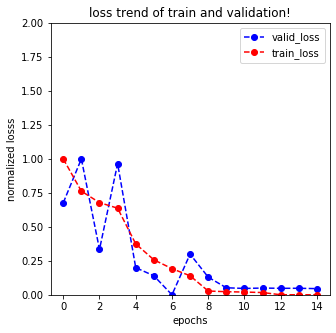

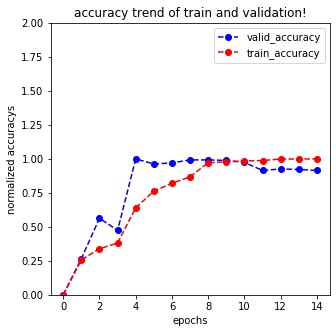

In [56]:
plot_logs(valid_loss_array, train_loss_array , N_EPOCHS, label_log="loss")
plot_logs(valid_acc_array, train_acc_array , N_EPOCHS, label_log="accuracy")

In [67]:
print('Building test model and loading the saved model...')

VOCAB_SIZE_TEST = len(test_dataset.get_vocab())
EMBED_DIM_TEST = 32
HIDDEN_DIM_TEST = 16
NUM_CLASS_TEST = len(test_dataset.get_labels())

model_test = LSTMmodel(VOCAB_SIZE_TEST,HIDDEN_DIM_TEST,EMBED_DIM_TEST,NUM_CLASS_TEST)
model_test.load_state_dict(torch.load('/content/gdrive/My Drive/weights_NN/Experiment2/finetune2_0.9774166666666667_.pt'))
model_test.cuda().eval()

Building test model and loading the saved model...


LSTMmodel(
  (embeddings): EmbeddingBag(1308844, 32, mode=mean)
  (lstm): LSTM(32, 16)
  (dropout): Dropout(p=0.85, inplace=False)
  (linear): Linear(in_features=16, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [68]:
# Testing error calculation

test_loss, test_acc = test(test_dataset, model_test)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

	Loss: 0.0001(test)	|	Acc: 92.0%(test)


In [0]:
import urllib.request
from inscriptis import get_text

def get_text_url(url_link):
  html = urllib.request.urlopen(url_link).read().decode('utf-8')
  return get_text(html)

In [0]:
# importing necessary libraries

import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

# labels for the AG_NEWS dataset

ag_news_label = {1 : "World",
                 2 : "Sports",
                 3 : "Business",
                 4 : "Sci/Tec"}

def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

vocab = train_dataset.get_vocab()
model = model.to("cpu")

In [0]:
# TESTING WITH RANDOM TEXTS

In [0]:
url_random_travel = "https://www.nytimes.com/2020/01/22/sports/football/eli-manning-retirement.html"
print("This is a '%s' news" % ag_news_label[predict(get_text_url(url_random_travel), model, vocab, NGRAMS)])

This is a 'Sports' news


In [0]:
text_test = "Amazon, Alphabet, Alibaba, Facebook, Tencent - five of the world's 10 most valuable companies,\
all less than 25 years old - and all got rich, in their own ways, on data.No wonder it's become common to call data the 'new oil'.\
As recently as 2011, five of the top 10 were oil companies. Now, only ExxonMobil clings on.\
The analogy isn't perfect. Data can be used many times, oil only once.\
But data is like oil in that the crude, unrefined stuff is not much use to anyone.\
You have to process it to get something valuable. fortnightYou refine oil to make diesel, to put it in an engine.\
With data, you need to analyse it to provide insights that can inform decisions - which advert to insert in a social media timeline, which search result to put at the top of the page.\
Imagine you were asked to make just one of those decisions.\
Someone is watching a video on YouTube, which is run by Google, which is owned by Alphabet. What should the system suggest they watch next?\
 Pique their interest, and YouTube gets to serve them another advert. Lose their attention, and they will click away.\
You have all the data you need. Consider every other YouTube video they have ever watched - what are they interested in? Now, look at what other users have gone on to watch after this video.\
Weigh up the options, calculate probabilities. If you choose wisely, and they view another ad, well done - you've earned Alphabet all of, ooh, maybe 20 cents (15p).\
Clearly, relying on humans to process data would be impossibly inefficient. These business models need machines.\
In the data economy, power comes not from data alone but from the interplay of data and algorithm."

print("This is a '%s' news" % ag_news_label[predict(text_test, model, vocab, NGRAMS)])

This is a 'Business' news


In [0]:
test_text2 = "Demand for iPhones appears to be flourishing once again in China, a year after Apple had to warn investors that the Chinese market was facing a serious slow down.\
IPhone sales in China were up 18% in December from the same month a year earlier, an even better performance than Wall Street had projected, according to an investor note from Wedbush analyst Dan Ives. Apple (AAPL) shipped around 3.2 million iPhones to China during the month compared to 2.7 million in December 2018, Ives reported, citing data from the China Academy of Information and Communication Technology.\
It's good news for Apple, after iPhone sales tumbled in China over the past year.\
'Our belief that China will continue this positive upward trajectory with renewed growth and share gains on the heels of an iPhone 11 product cycle which the skeptics continue to underestimate,' Ives said in the Thursday note.\
The good news was reflected in Apple's stock, which was up nearly 2% to a record high on Thursday.\
China is a key market for Apple — the region makes up nearly 17% of the company's total sales. And the iPhone is Apple's biggest profit driver.\
In early January 2019, Apple CEO Tim Cook wrote a letter to investors warning them to expect lower sales from the holiday quarter due primarily to iPhone sales in China falling short of what the company had expected. It was the first time since June 2002 that Apple issued a reduction in its quarterly revenue forecast. When the company reported earnings for that quarter later in January, iPhone sales had fallen 15% from the prior year.\
A number of factors contributed to the drop, namely slower growth in the Chinese economy and the US-China trade war.\
The trend continued throughout much of last year.\
In April, Apple said its iPhone sales in the first three months of 2019 dropped 17% from the same period a year earlier, again because of sluggish demand in China. A month later, Citi analysts warned that the trade war could cause Apple's iPhone sales in China to be cut in half.\
In the three months ending in June 2019, iPhones made up less than half of the company's revenue for the first time in years, though the slump also coincided with a greater focus at Apple on subscription-based services such as Apple Music.\
But the iPhone 11, which Apple introduced in September with better camera technology and battery life, as well as lower-than-expected prices, has helped with the rebound, Ives said. Early demand for the new model was strong, and in Apple's October earnings call, Cook noted that the company's prospects in China were turning around.\
Now, Ives estimates that there are roughly 60 million to 70 million iPhone users in China who are likely to upgrade their phones in the coming months.\
The momentum probably will continue this year, as Apple analysts widely expect Apple to release a 5G-enabled version of the iPhone in the fall.\
'Many investors are asking us: Is all the good news baked into shares after an historic upward move over the last year?' Ives said in the note. 'The answer from our vantage point is a resounding NO, as we view [this as] only the first part of this massive upgrade opportunity."

print("This is a '%s' news" % ag_news_label[predict(test_text2, model, vocab, NGRAMS)])

This is a 'Sci/Tec' news


In [0]:
fortnight = "Microsoft on Wednesday said it conducted an investigation into a security breach of one of its customer databases and found records could have been exposed for\
a short period in December. A misconfiguration in a database's Azure security rules on Dec. 5 enabled exposure to millions of customer support records, according to a blog post from Microsoft on Wednesday. After being alerted of the issue, \
engineers fixed the problem as of Dec. 31. The company says there was no malicious use of the data but is disclosing the breach to be transparent to its customers.\
Misconfigurations are unfortunately a common error across the industry, the company said.\
We have solutions to help prevent this kind of mistake, but unfortunately, they were not enabled for this database. As we've learned, it is good to periodically review your own configurations and ensure you are taking advantage of all protections available.\
Most customer data stored in the databases had personal information redacted, Microsoft said. The company said it'll contact customers whose info may have not been redacted.\
Bob Diachenko, a security researcher with Comparitech, discovered the security lapse on Dec. 28. He alerted Microsoft about the issue on Dec. 29 leading to the fix two days later. "

print("This is a '%s' news" % ag_news_label[predict(fortnight, model, vocab, NGRAMS)])

This is a 'Sci/Tec' news
